# 0. Install Dependencies

In [1]:
!pip3 install pandas --quiet
!pip3 install openpyxl --quiet
!pip3 install plotly-express --quiet
!pip3 install xlwings --quiet
!pip3 install matplotlib --quiet
!pip3 install nbformat --quiet

!xlwings config create --force

xlwings version: 0.27.10


# 1. Merge Excel Files (Simple)

### Merge multiple Excel files, perform calcs, export plolty chart (HTML)

In [21]:
from pathlib import Path
import pandas as pd  # pip install pandas
import plotly.express as px  # pip install plotly-express

In [22]:
# Locate examples files
INPUT_DIR = Path.cwd() / "1-Merge-Excel" / "INPUT"
OUTPUT_DIR = Path.cwd() / "1-Merge-Excel"

In [23]:
# Create empty dataframe, iterate over input directory, append all excel files to empty dataframe
df = pd.DataFrame()

# If you want to iterate over all folders including subfolders, use: 
# for file in INPUT_DIR.rglob("*"):

for file in INPUT_DIR.iterdir():
    if file.suffix == ".xlsx":
        df = pd.concat([df, pd.read_excel(file)])
    
df['Country'].unique()

array(['Germany', 'Canada', 'United States of America', 'Japan', 'France'],
      dtype=object)

In [24]:
df.head()

,Segment,Country,Product,Discount Band,Units Sold,Manufacturing Price,Sale Price,Gross Sales,Discounts,Sales,COGS,Profit,Date,Month Number,Month Name,Year
0,Government,Germany,Carretera,None,1321.0,3,20,26420.0,0.0,26420.0,13210.0,13210.0,2021-01-01,1,January,2021
1,Midmarket,Germany,Carretera,None,888.0,3,15,13320.0,0.0,13320.0,8880.0,4440.0,2021-06-01,6,June,2021
2,Government,Germany,Carretera,None,1513.0,3,350,529550.0,0.0,529550.0,393380.0,136170.0,2021-12-01,12,December,2021
3,Midmarket,Germany,Montana,None,921.0,5,15,13815.0,0.0,13815.0,9210.0,4605.0,2021-03-01,3,March,2021
4,Channel Partners,Germany,Montana,None,1545.0,5,12,18540.0,0.0,18540.0,4635.0,13905.0,2021-06-01,6,June,2021


In [25]:
df = df.groupby(by="Country").sum()[[" Sales", "Profit"]]
df

,Sales,Profit
Country,,
Canada,1.971177e+07,2725557.105
France,1.922138e+07,2969688.610
Germany,1.727761e+07,2562169.350
Japan,1.619493e+07,2314852.850
United States of America,1.990542e+07,2442969.835


In [26]:
df["Profit Margin %"] = (df["Profit"] / df[" Sales"]) * 100
df

,Sales,Profit,Profit Margin %
Country,,,
Canada,1.971177e+07,2725557.105,13.827057
France,1.922138e+07,2969688.610,15.449926
Germany,1.727761e+07,2562169.350,14.829424
Japan,1.619493e+07,2314852.850,14.293688
United States of America,1.990542e+07,2442969.835,12.272891


In [27]:
# Plot Profit situation & export grouped dataframe to Excel
fig = px.bar(
    df,
    x=df.index,
    y=" Sales",
    color="Profit Margin %",
    color_continuous_scale=["red", "yellow", "green"],
    template="plotly_white",
    title="<b>Profit Analysis</b>",
)
fig.write_html(str(OUTPUT_DIR / "profit_analysis.html"))
df.to_excel(OUTPUT_DIR / "summary.xlsx")
fig

# 2. Merge Excel Files (Basic Report)

### Merge multiple Excel files, perform calcs, and insert (Excel) charts [keeping formatting & formulas]

In [28]:
!xlwings runpython install

xlwings version: 0.27.10
Successfully enabled RunPython!


In [29]:
from pathlib import Path
import pandas as pd  # pip install pandas
import xlwings as xw  # pip install xlwings
import matplotlib
from xlwings import view

In [30]:
# Locate examples files
INPUT_DIR = Path.cwd() / "2-Merge-Excel" / "INPUT"
OUTPUT_DIR = Path.cwd() / "2-Merge-Excel"

In [31]:
# Create an empty workbook. This wb will be final output
summary_wb = xw.Book()
summary_sht = summary_wb.sheets[0]
summary_sht.name = "Summary"

In [32]:
# Iterate over each file in directory. Copy cell range & paste it into summary workbook (keeping formatting & formulas)

# If iterate over all folders including subfolders, use: 
# for file in INPUT_DIR.rglob("*"):

for file in INPUT_DIR.iterdir():
    if file.suffix == ".xlsx":
        wb = xw.Book(file)
        wb.app.display_alerts = False
        #wb.app.visible = False
        sht = wb.sheets("Overview")
        values = sht.range("B5").expand().copy()
        dest_last_row = summary_sht.range("A1").expand().last_cell.row + 1
        summary_sht.range(f"A{dest_last_row}").paste()
        wb.close()

In [33]:
# Insert & style header of summary workbook
header = [
    "Segment",
    "Country",
    "Product",
    "Discount Band",
    "Units Sold",
    "Sale Price",
    "Gross Sales",
    "Discounts",
    "Sales",
    "COGS",
    "Profit",
]
header_row = summary_sht.range("A1:K1")
header_row.value = header
header_row.font.bold = True
header_row.font.color = (255, 255, 255)
header_row.color = (119, 136, 153)

In [34]:
# Use pandas to perform calculations, e.g. data aggregation
df = summary_sht.range("A1").options(pd.DataFrame, expand="table").value
data_by_country = df.groupby(by="Country").sum()[["Sales"]]
data_by_country

,Sales
Country,
Canada,1.971177e+07
France,1.922138e+07
Germany,1.727761e+07
Japan,1.619493e+07
United States of America,1.990542e+07


In [35]:
# Insert grouped dataframe into summary workbook
summary_sht.range("M1").value = data_by_country

In [36]:
# Insert EXCEL chart
chart = summary_sht.charts.add(
    left=summary_sht.range("M8").left, 
    top=summary_sht.range("M8").top,
    width=400,
    height=200,
)
chart.set_source_data(summary_sht.range("M1").expand())
chart.chart_type = "bar_stacked"

In [37]:
# Insert PANDAS chart
ax = data_by_country.sort_values(by="Sales").plot(kind="barh")
fig = ax.get_figure()
summary_sht.pictures.add(
    fig,
    name="Sales",
    update=True,
    left=summary_sht.range("M23").left,
    top=summary_sht.range("M23").top,
    width=400,
    height=200,
)

<Picture 'Sales' in <Sheet [Book1]Summary>>

In [38]:
# Clean up workbook, save workbook & quit Excel instance (if only wb open)
summary_sht.autofit()
summary_wb.save(OUTPUT_DIR / "summary.xlsx")
if len(summary_wb.app.books) == 1:
    summary_wb.app.quit()
else:
    summary_wb.close()

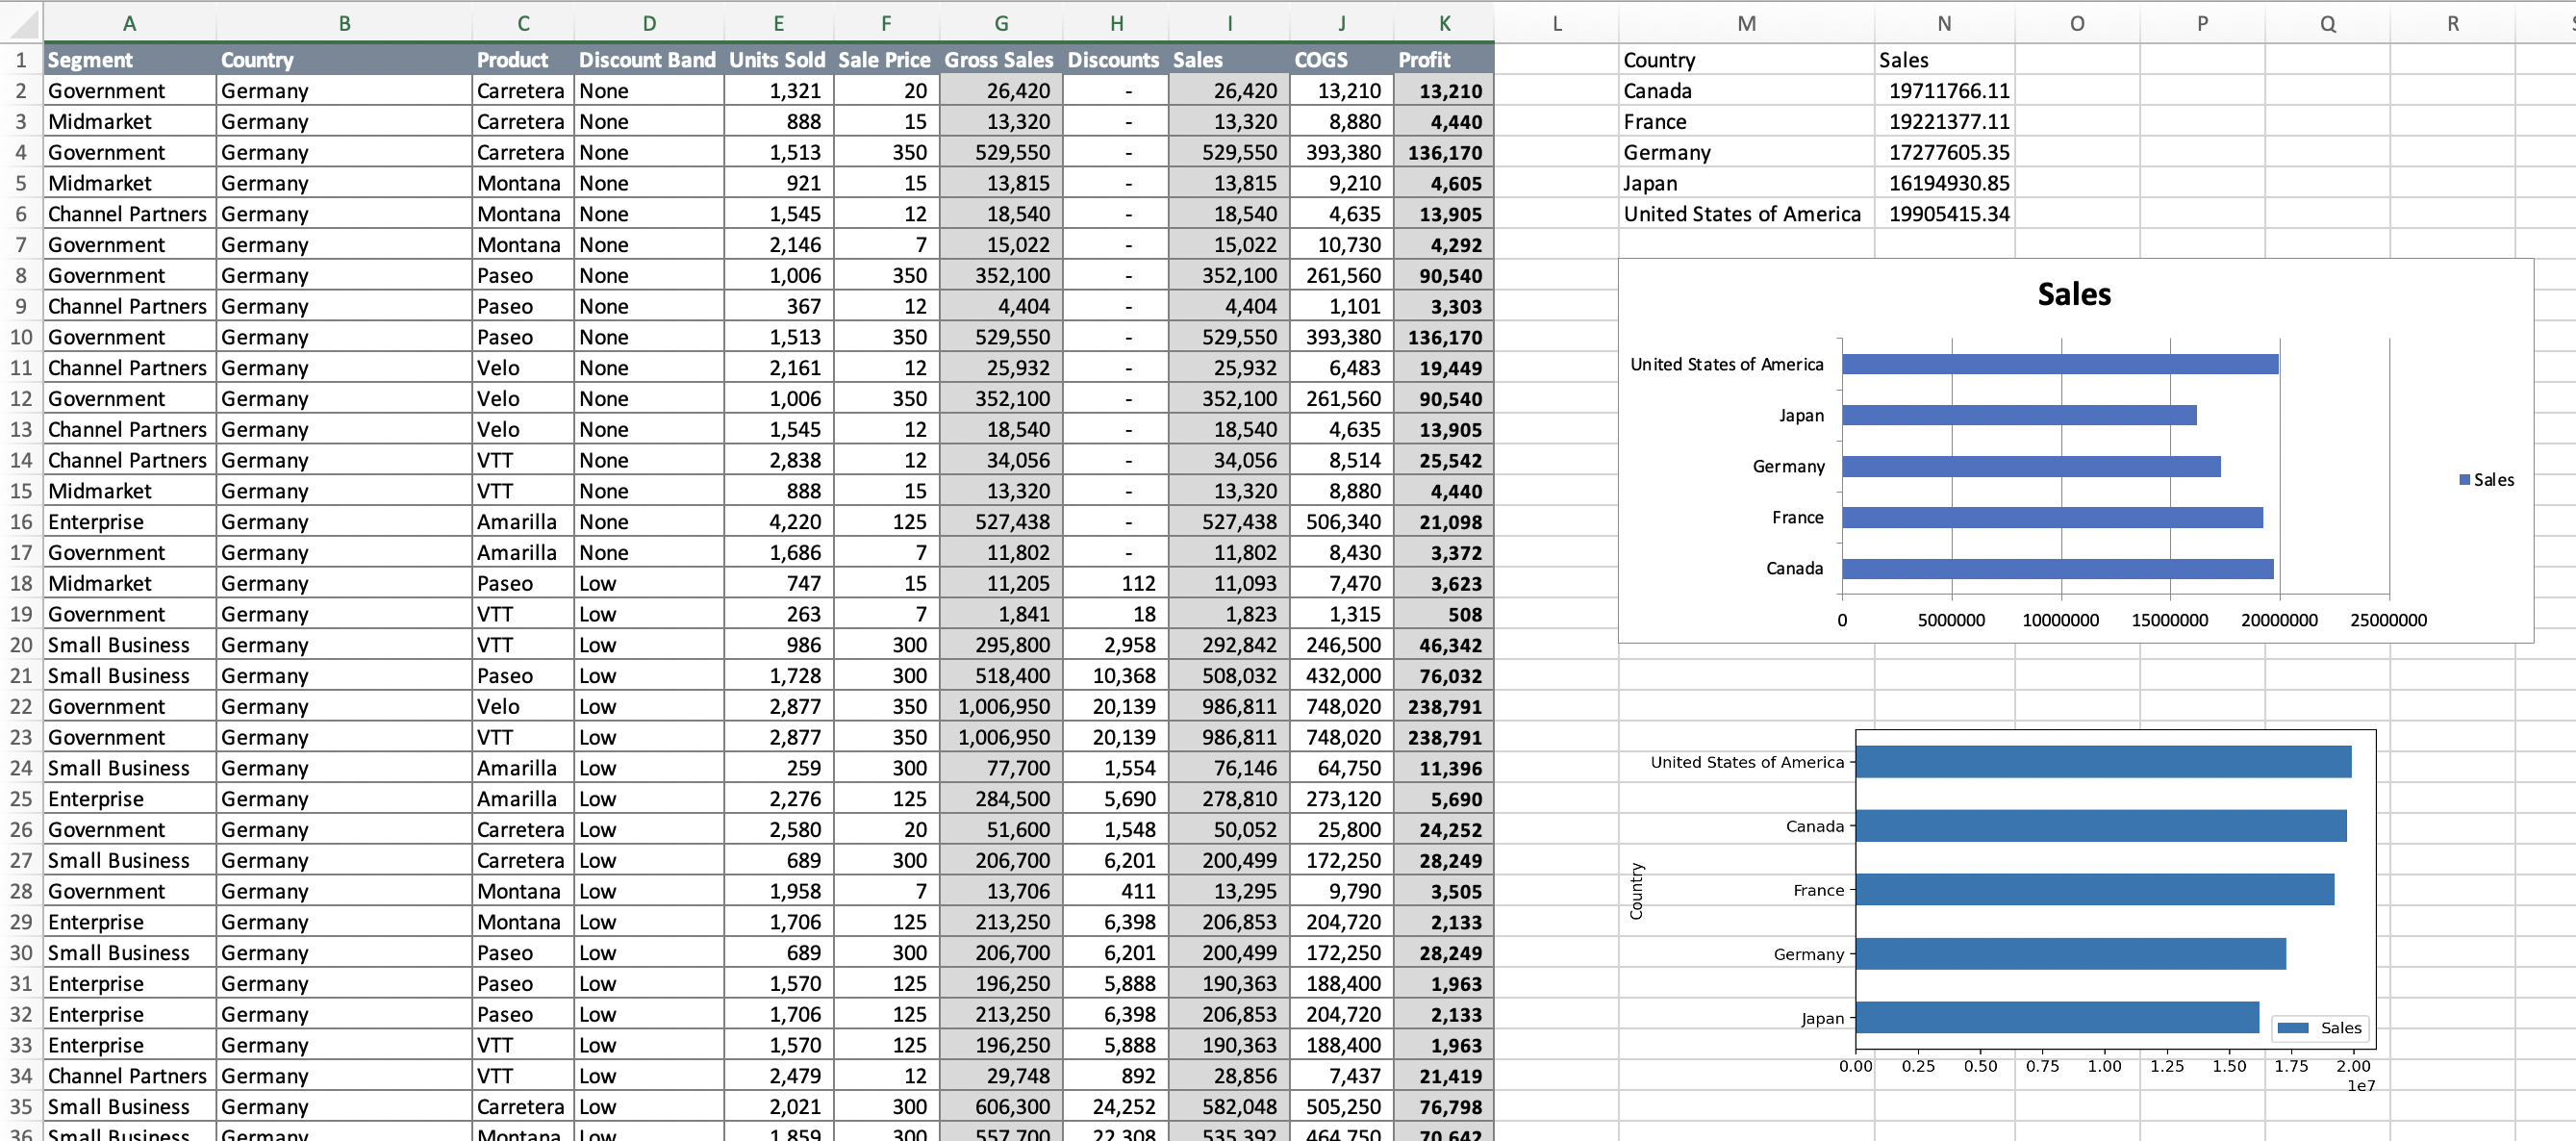